# Notebook for the evaluation of inter-annotator agreement scores (IAA)
Version : python 3.7

Last updated : 02/09/2021

Author : Lucas Terriel

## Tasks

- Retrieval of metadata on the raw file used for IAA evaluation (number of sentences, tokens, and characters);

- Total number of annotations by annotators on the text in general and by labels;

- Table of agreement and disagreement between annotators on the annotated mentions;

- Percentage of alignment and non-alignment;

- Compute Cohen Kappa for annotators pairs, Fleiss Kappa for the group and interpretation of Kappa;

- Histogram showing the number of mentions annotated by label for each annotator and label average used for the group;

- Alignment classes between the annotators.

### Mise en place des *packages* Python

In [7]:
from collections import Counter
from itertools import combinations
from os.path import basename, splitext
from os import walk
from math import trunc
import pprint
pp = pprint.PrettyPrinter(indent=2)

from cassis import *
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
import pandas as pd 
import statistics

[nltk_data] Downloading package punkt to /home/lterriel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Description of raw test file

In [8]:
# Change the file path
baseline_path = "./datatest/evaluation_sample/raw/baseline_IAA.txt"
filename = basename(baseline_path)
filename_no_extension = splitext(filename)[0]

# display results
print(f"\t\t** file description : {filename} **\n")
with open(baseline_path, "r", encoding="UTF-8") as f:
    file = f.read()
    sentences = sent_tokenize(file)
    words = word_tokenize(file)
    chars = len(file)
    print(f"""
              - Number of sentences : {len(sentences)}
              - Number of tokens :  {len(words)}
              - Numbers of characters : {chars}""")

		** file description : baseline_IAA.txt **


              - Number of sentences : 41
              - Number of tokens :  1154
              - Numbers of characters : 6321


### Processing of XMI files for each annotator with [dkpro-cassis *package*](https://pypi.org/project/dkpro-cassis/)

* All xmi files retrieved from INCEpTION annotation platform via upstream process used [PyCaprio](https://github.com/JavierLuna/pycaprio) API

In [9]:
# change the path to the folder containing each of the annotated files 
base_annots = "./datatest/evaluation_sample/annotators/"

typesystem_file = "TypeSystem.xml"

xmi_files = [file for _,_,files in walk(base_annots) for file in files if file != "TypeSystem.xml"]

# opening of the typesystem necessary to interpret the XMI schema 
with open(base_annots + typesystem_file, 'rb') as f:
    typesystem = load_typesystem(f)

# check
for xmi in xmi_files:
    print(xmi)

coder_3.xmi
coder_1.xmi
coder_4.xmi
coder_2.xmi


### Data structures necessary for the calculations 

In [10]:
Docs = {}
pairwise = {}
commune_mention = []


for xmi in xmi_files:
    annotations = {}
    labels = []
    person = os.path.splitext(xmi)[0]
    with open(base_annots + xmi, 'rb') as f:
        cas = load_cas_from_xmi(f, typesystem=typesystem)
        # change the layer if no corresponding in your typesystem.xml
        for ne in cas.select('de.tudarmstadt.ukp.dkpro.core.api.ner.type.NamedEntity'):
            annotations[ne.get_covered_text()] = ne.value
            commune_mention.append(ne.get_covered_text())
            labels.append(ne.value)
        
        pairwise[person] = labels
        Docs[person] = annotations
    

### Total number of annotations on the text grouped and by labels 

In [11]:
labels_ann = []
dicts_coders = []
for coder, annotations in Docs.items():
    nombre_annotations = []
    print(f'* {coder}')
    for annotation, label in annotations.items():
        nombre_annotations.append(label)
    print(f"Total number of annotations  : {len(nombre_annotations)}")
    dict_coder = dict(Counter(nombre_annotations))
    pp.pprint(dict_coder)
    dicts_coders.append(dict_coder)
    print(f'==========================')

* coder_3
Total number of annotations  : 134
{ 'EVENT': 6,
  'INSTALLATION': 5,
  'LOCATION': 60,
  'ORGANISATION': 17,
  'PERSON': 31,
  'TITLE': 15}
* coder_1
Total number of annotations  : 131
{ 'EVENT': 2,
  'INSTALLATION': 7,
  'LOCATION': 58,
  'ORGANISATION': 15,
  'PERSON': 32,
  'TITLE': 17}
* coder_4
Total number of annotations  : 134
{ 'EVENT': 3,
  'INSTALLATION': 4,
  'LOCATION': 58,
  'ORGANISATION': 20,
  'PERSON': 33,
  'TITLE': 16}
* coder_2
Total number of annotations  : 130
{ 'EVENT': 1,
  'INSTALLATION': 8,
  'LOCATION': 55,
  'ORGANISATION': 19,
  'PERSON': 32,
  'TITLE': 15}


### Dataframe initialization

In [12]:
commune_mention = list(dict.fromkeys(commune_mention))

data = [Docs]

# Dataframe from the mentions commonly annotated by the annotators   
df = pd.DataFrame(data, index =commune_mention) 

# Initialize dataframe values with None 
df['coder_1'] = 'None'
df['coder_2'] = 'None'
df['coder_3'] = 'None'
df['coder_4'] = 'None'

### Total number of annotations and visualization of the label proposed by each annotator for each admitted mentions 

In [13]:
annotators = ['coder_1', 'coder_2', 'coder_3', 'coder_4']

for ann in annotators:
    for mention,value in Docs[ann].items():
        df.loc[mention,ann] = value

total_annotations = len(df)

print(f'* Total annotations  : {total_annotations}')

df[0:10]

* Total annotations  : 172


,coder_3,coder_1,coder_4,coder_2
Chalon,LOCATION,LOCATION,LOCATION,LOCATION
Robinette Dardongne,PERSON,PERSON,PERSON,PERSON
Ochoa Dardogne,PERSON,PERSON,PERSON,PERSON
comté de Biscoye,ORGANISATION,TITLE,ORGANISATION,ORGANISATION
royaume de Castille,LOCATION,ORGANISATION,ORGANISATION,ORGANISATION
bailliage de Sens,ORGANISATION,ORGANISATION,ORGANISATION,ORGANISATION
Jeanne de Villiers,PERSON,PERSON,PERSON,PERSON
Dijon,LOCATION,LOCATION,LOCATION,LOCATION
Jean Le Denoys,PERSON,PERSON,PERSON,PERSON
compagnon teinturier,TITLE,None,TITLE,TITLE


###  Agreement and disagreement table between annotators on the annotated mentions and percentage of alignment and non-alignment 

#### Agreement between annotators 

In [14]:
columns_to_compare = annotators

def check_all_equal(iterator):
    return len(set(iterator)) <= 1

df_agree = df[df[columns_to_compare].apply(lambda row: check_all_equal(row), axis=1)]
total_unanime = len(df_agree)

# alignment
print(f"* Total unanimous annotations  : {total_unanime} / {total_annotations} annotations either  {(total_unanime/total_annotations) * 100} % alignment")

# df export
df_agree.to_csv(f'./out/agree_{filename_no_extension}.csv', encoding='utf-8')

# preview 
df_agree[0:10]

* Total unanimous annotations  : 90 / 172 annotations either  52.32558139534884 % alignment


,coder_3,coder_1,coder_4,coder_2
Chalon,LOCATION,LOCATION,LOCATION,LOCATION
Robinette Dardongne,PERSON,PERSON,PERSON,PERSON
Ochoa Dardogne,PERSON,PERSON,PERSON,PERSON
bailliage de Sens,ORGANISATION,ORGANISATION,ORGANISATION,ORGANISATION
Jeanne de Villiers,PERSON,PERSON,PERSON,PERSON
Dijon,LOCATION,LOCATION,LOCATION,LOCATION
Jean Le Denoys,PERSON,PERSON,PERSON,PERSON
Gevrey-en-Montagne,LOCATION,LOCATION,LOCATION,LOCATION
bailliage de Dijon,ORGANISATION,ORGANISATION,ORGANISATION,ORGANISATION
chambellan du roi,TITLE,TITLE,TITLE,TITLE


#### Disagreement between annotators 

In [15]:
columns_to_compare = annotators
def check_all_not_equal(iterator):
    return len(set(iterator)) > 1

df_disagree = df[df[columns_to_compare].apply(lambda row: check_all_not_equal(row), axis=1)]
total_desaccord = len(df_disagree)

# non-alignment
print(f"* Total disagreement annotations:  {total_desaccord} / {total_annotations} annotations either  {(total_desaccord/total_annotations) * 100} % of non-alignment")

# df export
df_disagree.to_csv(f'./out/disagree_{filename_no_extension}.csv', encoding='utf-8')

# preview 
df_disagree[20:40]

* Total disagreement annotations:  82 / 172 annotations either  47.674418604651166 % of non-alignment


,coder_3,coder_1,coder_4,coder_2
lycée Louis-le-Grand,ORGANISATION,INSTALLATION,ORGANISATION,ORGANISATION
"Lyon (Rhône), 53, passage de l'Hôtel-Dieu",LOCATION,None,None,None
commune de Ronquerolles,LOCATION,None,None,None
arrondissement de Pontoise,LOCATION,None,LOCATION,LOCATION
Parc De Chambon,INSTALLATION,INSTALLATION,INSTALLATION,None
Châteaux De Chambon,INSTALLATION,INSTALLATION,None,None
Rilly,LOCATION,LOCATION,LOCATION,None
Château Dudit Chambon,INSTALLATION,None,None,INSTALLATION
Bois De Clerembault,LOCATION,None,None,None
Étangs De Rilly,LOCATION,None,None,None


### Compute Cohen Kappa for pairs of annotators, Fleiss Kappa for the group and interpretation of Kappa 

- source code adapted : [De Brujn, L., *Inter-Annotator Agreement (IAA)*, towards data science, 2020](https://towardsdatascience.com/inter-annotator-agreement-2f46c6d37bf3)
- for the interpretation of Kappa  : [Anthony J. Viera, MD, Garrett, J.M., *Understanding Interobserver Agreement:The Kappa Statistic*, 2005](http://www1.cs.columbia.edu/~julia/courses/CS6998/Interrater_agreement.Kappa_statistic.pdf)

In [16]:
df_n = df.apply(pd.Series.value_counts, 1).fillna(0).astype(int)
matrix = df_n.values

def cohen_kappa_function(ann1, ann2):
    """Computes Cohen kappa for pair-wise annotators.
    :param ann1: annotations provided by first annotator
    :type ann1: list
    :param ann2: annotations provided by second annotator
    :type ann2: list
    :rtype: float
    :return: Cohen kappa statistic
    """
    count = 0
    for an1, an2 in zip(ann1, ann2):
        if an1 == an2:
            count += 1
    A = count / len(ann1)  # observed agreement A (Po)

    uniq = set(ann1 + ann2)
    E = 0  # expected agreement E (Pe)
    for item in uniq:
        cnt1 = ann1.count(item)
        cnt2 = ann2.count(item)
        count = (cnt1 / len(ann1)) * (cnt2 / len(ann2))
        E += count

    return round((A - E) / (1 - E), 4)


def fleiss_kappa_function(M):
    """Computes Fleiss' kappa for group of annotators.
    :param M: a matrix of shape (:attr:'N', :attr:'k') with 'N' = number of subjects and 'k' = the number of categories.
        'M[i, j]' represent the number of raters who assigned the 'i'th subject to the 'j'th category.
    :type: numpy matrix
    :rtype: float
    :return: Fleiss' kappa score
    """
    N, k = M.shape  # N is # of items, k is # of categories
    n_annotators = float(np.sum(M[0, :]))  # # of annotators
    tot_annotations = N * n_annotators  # the total # of annotations
    category_sum = np.sum(M, axis=0)  # the sum of each category over all items

    # chance agreement
    p = category_sum / tot_annotations  # the distribution of each category over all annotations
    PbarE = np.sum(p * p)  # average chance agreement over all categories

    # observed agreement
    P = (np.sum(M * M, axis=1) - n_annotators) / (n_annotators * (n_annotators - 1))
    Pbar = np.sum(P) / N  # add all observed agreement chances per item and divide by amount of items

    return round((Pbar - PbarE) / (1 - PbarE), 4)

def interpret_kappa(score):
    if score < 0:
        return "Less chance agreement\n"
    elif 0.01 <= score <= 0.20:
        return "Slight agreement\n"
    elif 0.21 <= score <= 0.40:
        return "Fair agreement\n"
    elif 0.41 <= score <= 0.60:
        return "Moderate agreement\n"
    elif 0.61 <= score <= 0.80:
        return "Substantial agreement\n"
    elif 0.81 <= score <= 0.99:
        return "Almost perfect agreement\n"

pairs = list(combinations(annotators, 2))

print("\t\t -- Results Cohen Kappa --\n")
for coder_1, coder_2 in pairs:
    cohen_function = cohen_kappa_function(pairwise[coder_1], pairwise[coder_2])
    print(f"* {coder_1} <> {coder_2} : {cohen_function}")
    print(f"\t|=>{interpret_kappa(cohen_function)}")
    
print("\n")

fleiss_function = fleiss_kappa_function(matrix)

print(f"-- Fleiss'Kappa score for group -X- : {fleiss_function}")
print(f"\t|=>{interpret_kappa(fleiss_function)}")

		 -- Results Cohen Kappa --

* coder_1 <> coder_2 : 0.2619
	|=>Fair agreement

* coder_1 <> coder_3 : 0.295
	|=>Fair agreement

* coder_1 <> coder_4 : 0.2264
	|=>Fair agreement

* coder_2 <> coder_3 : 0.1579
	|=>Slight agreement

* coder_2 <> coder_4 : 0.1274
	|=>Slight agreement

* coder_3 <> coder_4 : 0.2945
	|=>Fair agreement



-- Fleiss'Kappa score for group -X- : 0.664
	|=>Substantial agreement



### Histogram showing the number of mentions annotated by label for each annotator and label average used for the group 

In [17]:
# creation of the data structure for the establishment of the histogram 
dict_to_histogram = {
    k: [0 if d.get(k) == None else d.get(k) for d in dicts_coders]
    for k in set().union(*dicts_coders)
}

for i in dict_to_histogram.items():
    print(i)

('INSTALLATION', [5, 7, 4, 8])
('ORGANISATION', [17, 15, 20, 19])
('TITLE', [15, 17, 16, 15])
('LOCATION', [60, 58, 58, 55])
('PERSON', [31, 32, 33, 32])
('EVENT', [6, 2, 3, 1])


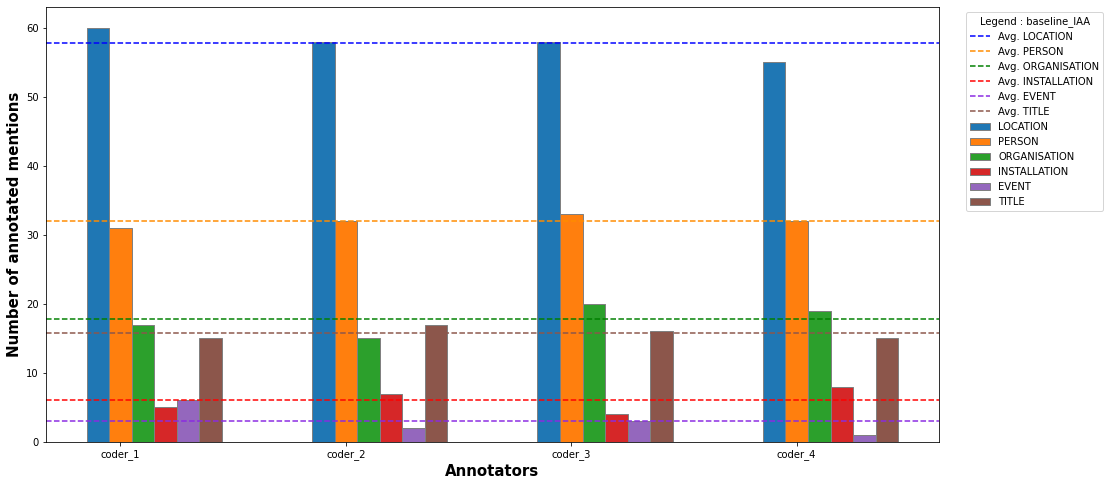

In [18]:
# to be adapted according to the types of labels, the number of annotators  
 
# general params of figure
barWidth = 0.10
fig = plt.subplots(figsize =(16, 8))

# bar height adjustment 
LOCATION = dict_to_histogram['LOCATION']
PERSON = dict_to_histogram['PERSON']
ORGANISATION = dict_to_histogram['ORGANISATION']
INSTALLATION = dict_to_histogram['INSTALLATION']
EVENT = dict_to_histogram['EVENT']
#UNKNOWN = dict_to_histogram['UNKNOWN']
#LEGAL = dict_to_histogram['LEGAL']
TITLE = dict_to_histogram['TITLE']
#INSTITUTION = dict_to_histogram['INSTITUTION']

# choose the position of the bars on the x-axis (X) 
br1 = np.arange(len(LOCATION))
br2 = [x + barWidth for x in br1]
br3 = [x1 + barWidth for x1 in br2]
br4 = [x2 + barWidth for x2 in br3]
br5 = [x3 + barWidth for x3 in br4]
br6 = [x4 + barWidth for x4 in br5]
br7 = [x5 + barWidth for x5 in br6]
br8 = [x6 + barWidth for x6 in br7]
br9 = [x6 + barWidth for x6 in br8]

# create the bar and average line (colors, font style ...) 

plt.bar(br1, 
        LOCATION, 
        width = barWidth,
        edgecolor ='grey', 
        label ='LOCATION')
plt.axhline(y = statistics.mean(LOCATION), color = 'b', linestyle = '--', label = "Avg. LOCATION")

plt.bar(br2, 
        PERSON, 
        width = barWidth,
        edgecolor ='grey', 
        label ='PERSON')
plt.axhline(y = statistics.mean(PERSON), color = 'darkorange', linestyle = '--', label = "Avg. PERSON")

plt.bar(br3, 
        ORGANISATION, 
        width = barWidth,
        edgecolor ='grey', 
        label ='ORGANISATION')
plt.axhline(y = statistics.mean(ORGANISATION), color = 'g', linestyle = '--', label = "Avg. ORGANISATION")

plt.bar(br4, 
        INSTALLATION, 
        width = barWidth,
        edgecolor ='grey', 
        label ='INSTALLATION')
plt.axhline(y = statistics.mean(INSTALLATION), color = 'r', linestyle = '--', label = "Avg. INSTALLATION")

plt.bar(br5, 
        EVENT, 
        width = barWidth,
        edgecolor ='grey', 
        label ='EVENT')
plt.axhline(y = statistics.mean(EVENT), color = 'blueviolet', linestyle = '--', label = "Avg. EVENT")

"""
plt.bar(br6, 
        UNKNOWN, 
        width = barWidth,
        edgecolor ='grey', 
        label ='UNKNOWN')
plt.axhline(y = statistics.mean(UNKNOWN), color = 'tab:brown', linestyle = '--', label = "Avg. UNKNOWN")
"""
"""
plt.bar(br7, 
        LEGAL,  
        width = barWidth,
        edgecolor ='grey', 
        label ='LEGAL')
#plt.axhline(y = statistics.mean(LEGAL), color = 'tab:pink', linestyle = '--', label = "Avg. LEGAL")
"""
plt.bar(br6, 
        TITLE,  
        width = barWidth,
        edgecolor ='grey', 
        label ='TITLE')
plt.axhline(y = statistics.mean(TITLE), color = 'tab:brown', linestyle = '--', label = "Avg. TITLE")

"""
plt.bar(br7, 
        INSTITUTION,  
        width = barWidth,
        edgecolor ='grey', 
        label ='INSTITUTION')
#plt.axhline(y = statistics.mean(INSTITUTION), color = 'r', linestyle = '--', label = "Avg. INSTITUTION")
"""

plt.xlabel('Annotators', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of annotated mentions', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(annotators))],
        annotators)

# export of the histogram
plt.savefig(f'./out/labels_per_annotators_{filename_no_extension}.png', dpi=400)
# preview
plt.legend(title=f'Legend : {filename_no_extension}', bbox_to_anchor=(1.19, 1), loc='upper right')
plt.show()

### Evaluation of the alignment of classes between annotators 

In [19]:
labels = ['LOCATION', 'PERSON', 'ORGANISATION', 'INSTALLATION', 'EVENT', 'TITLE']

# Retrieve the total of mentions annotated with a type of class 

def count_total_annotations_label(dataframe, labels):
    """Total number of lines (annotated entries) carrying at least one class""" 
    pairs = []
    for label in labels:
        total = dataframe.astype(object).eq(label).any(1).sum()
        pairs.append((label, total))
    return pairs

totals_annotations_per_labels = count_total_annotations_label(df, labels)

# Retrieve the number of mentions with the same class according to the annotators 

def total_agree_disagree_per_label(dataframe, pairs_totals_labels):
    """
    For each class:
     1. Number of mentions where the annotators put the same class;
     2. Number of mentions where the annotators did not agree on the class;
     3. Conversion to percentage;
     4. Recovery of the class, of the total number of mentions with "at least" the class, percentage of mentions annotated with the same class,
     and percentage of annotated mentions carrying the class for at least one annotator. 
    """
    new_pairs = []
    for t in pairs_totals_labels:
        # t[0] : label
        # t[1] : total_rows_with_label
        agree_res = df[df.nunique(1).eq(1)].eq(t[0]).any(1).sum()
        disagree_res = t[1] - agree_res
        agree_percent = (agree_res / t[1]) * 100
        disagree_percent = (disagree_res / t[1]) * 100
        new_pairs.append((t[0], t[1], agree_percent, disagree_percent))
    return new_pairs

to_pie = total_agree_disagree_per_label(df, totals_annotations_per_labels)

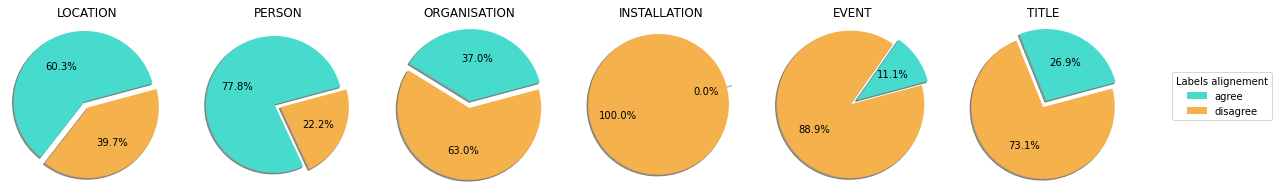

In [20]:
def plot_pies(tasks_to_pie):
    """Creation of a pie chart by class according to a report of agreement and disagreement by annotators 
    """
    my_labels = 'agree','disagree'
    my_colors = ['#47DBCD','#F5B14C']
    my_explode = (0, 0.1)
    counter = 0
    fig, axes = plt.subplots(1, len(tasks_to_pie),figsize=(20,3))
    for t in tasks_to_pie:
        tasks = [t[2], t[3]]
        axes[counter].pie(tasks, autopct='%1.1f%%', startangle=15, shadow = True, colors=my_colors, explode=my_explode)
        axes[counter].set_title(t[0])
        axes[counter].axis('equal')
        counter +=1
    fig.set_facecolor("white")
    fig.legend(labels=my_labels, loc="center right", borderaxespad=0.1, title="Labels alignement")
    plt.savefig(f'./out/pie_alignement_labels_{filename_no_extension}.png', dpi=400)
    return plt.show()

plot_pies(to_pie)
